# 标题

In [1]:
import pandas as pd
df = pd.read_csv('datasets/F-F_Research_Data_Factors_weekly_CSV.csv', index_col=0)
df.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
19260702,1.60,-0.62,-0.83,0.056
19260710,0.36,-0.88,0.31,0.056
19260717,1.01,0.59,-1.44,0.056
19260724,-2.05,0.10,-0.18,0.056
19260731,3.04,-1.82,-0.90,0.056


In [2]:
df = df[['Mkt-RF', 'SMB', 'HML']]
name_dict = {'Mkt-RF':'Market Factor (MER)',
            'SMB':'Size Factor (SMB)',
            'HML':'Value Factor (HML)'}

In [3]:
df.columns = [name_dict[i] for i in df.columns]
df.index = df.index.astype(str)
df.index = pd.to_datetime(df.index, format='%Y%m%d')

In [4]:
df.loc[df.index>pd.to_datetime('2010-01-01'), :]

,Market Factor (MER),Size Factor (SMB),Value Factor (HML)
Date,,,
2010-01-08,2.89,0.21,3.92
2010-01-15,-0.91,0.10,-1.53
2010-01-22,-3.57,0.91,-1.88
2010-01-29,-1.70,-0.71,0.09
2010-02-05,-0.81,-0.71,-0.07
...,...,...,...
2023-03-31,3.56,-0.09,-0.10
2023-04-06,-0.51,-2.67,0.97
2023-04-14,0.91,0.10,0.24


In [5]:
import pandas as pd
BRK = pd.read_csv('datasets/BRKa历史数据.csv', index_col=0)
BRK = BRK.sort_index()
BRK.index = pd.to_datetime(BRK.index, format='%Y-%m-%d')
BRK.head()

,收盘,开盘,高,低,交易量,涨跌幅
日期,,,,,,
2010-01-11,"99,999","100,100","100,750","99,320",1.95K,-0.30%
2010-01-12,"99,350","99,505","99,949","99,350",2.23K,-0.65%
2010-01-13,"99,150","99,400","99,949","99,150",1.02K,-0.20%
2010-01-14,"99,000","99,160","99,480","98,920",1.43K,-0.15%
2010-01-15,"97,500","99,000","99,363","97,205",2.66K,-1.52%


In [6]:
import numpy as np
BRK['收盘'] = np.array([i.replace(',', '') for i in BRK['收盘']], dtype='float')

<AxesSubplot:title={'center':'伯克希尔哈撒韦公司的股价'}, xlabel='日期'>

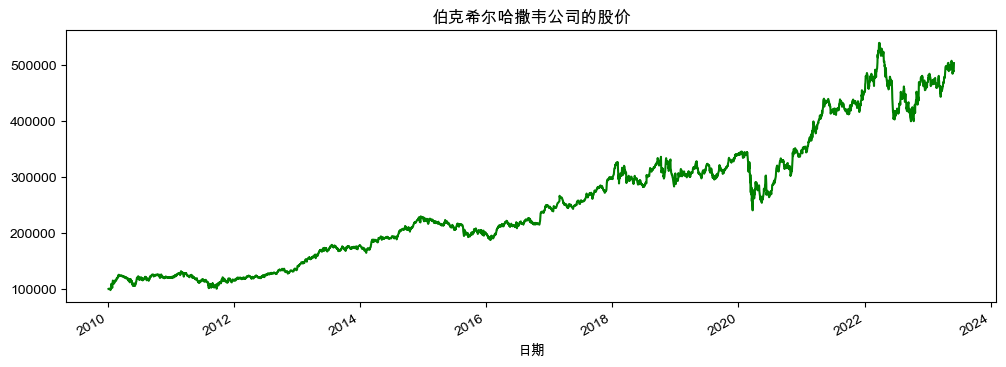

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False 
BRK['收盘'].plot(figsize=(12,4), title='伯克希尔哈撒韦公司的股价', color='green')

<AxesSubplot:title={'center':'伯克希尔哈撒韦公司的股价'}, xlabel='Date'>

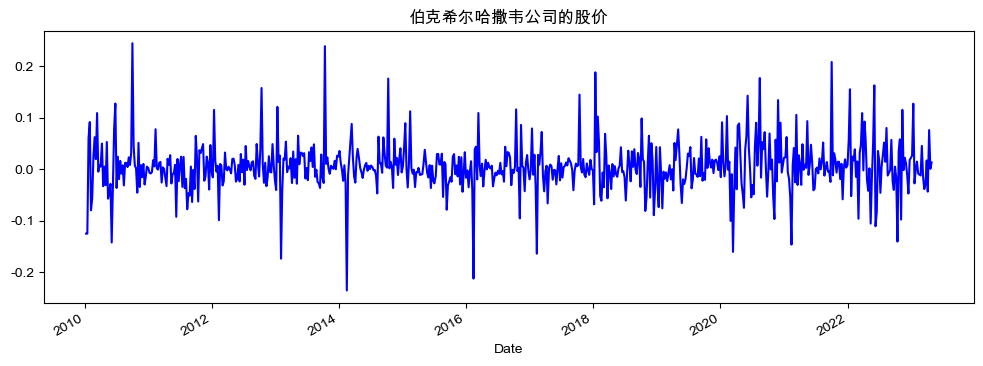

In [8]:
df['BRK收盘'] = BRK['收盘']
df['BRK收盘_shift_5'] = BRK['收盘'].shift(5)
df['Return'] = df['BRK收盘']/df['BRK收盘_shift_5'] - 1
df['Return'] = df['Return'].fillna(method='ffill') #forward fill向前填充，过去的数据填充今天的
df = df.loc[df.index>pd.to_datetime('2010-01-01'), :]
df['Return'].plot(figsize=(12,4), title='伯克希尔哈撒韦公司的股价', color='blue')

<AxesSubplot:>

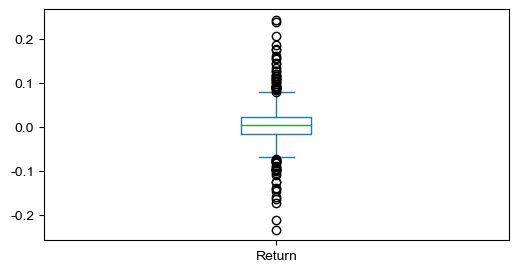

In [9]:
df['Return'].plot(kind='box', grid=False, figsize=(6,3))

<AxesSubplot:>

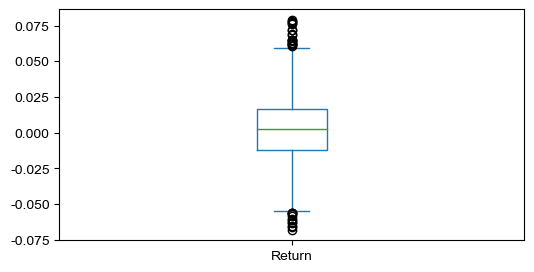

In [10]:
import numpy as np
QU = df['Return'].quantile(0.75)
QL = df['Return'].quantile(0.25)
IQR = QU - QL
df['Return'][(df['Return']>(QU + 1.5*IQR)) | (df['Return']<(QL-1.5*IQR))] = np.nan
df.loc[:, 'Return'] = df['Return'].fillna(df['Return'].quantile(0.5))
df['Return'].plot(kind='box', grid=False, figsize=(6,3))

<AxesSubplot:>

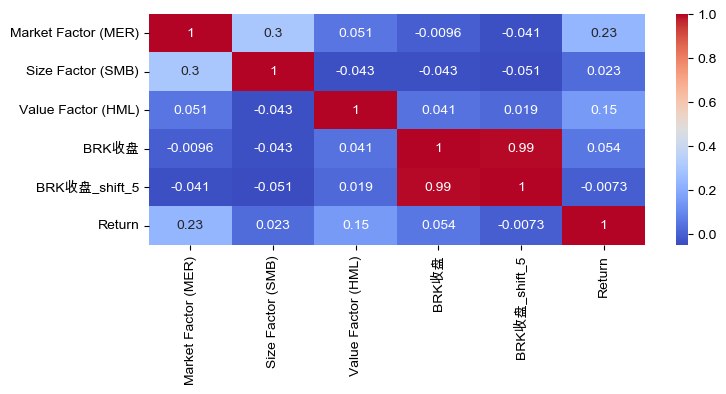

In [11]:
import seaborn as sns
plt.figure(figsize=(8,3))
sns.heatmap(df.corr(), annot = True, cmap='coolwarm')

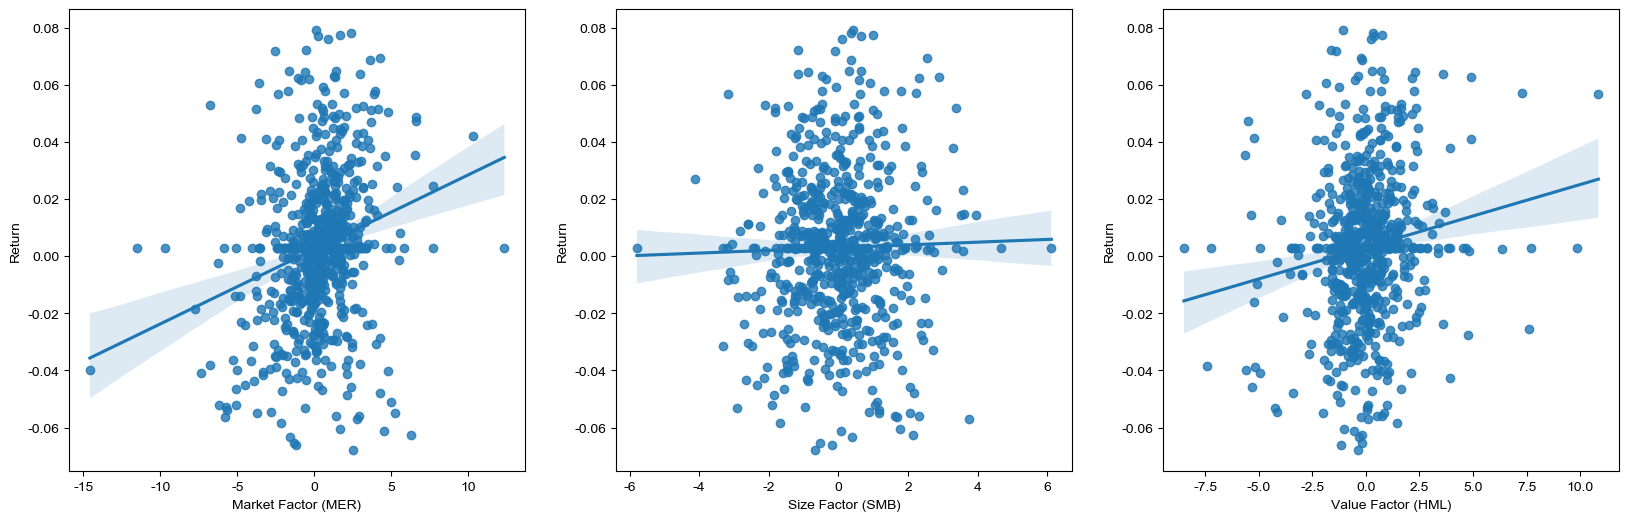

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
for i, k in enumerate(['Market Factor (MER)', 'Size Factor (SMB)', 'Value Factor (HML)']):
    sns.regplot(y=df['Return'], x=df[k], ax=axs[i])

# Fama-MacBeth回归

## 滑动周期回归

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
df = df.sort_values('Date')
X = df[['Market Factor (MER)', 'Size Factor (SMB)', 'Value Factor (HML)']]
y = df['Return']
X = sm.add_constant(X)
window_size = 20 #滑动周期为52周（一年）
regressions = []
for i in range(len(df) - window_size + 1):
    X_window = X.iloc[i:i+window_size]
    y_window = y.iloc[i:i+window_size]
    model = sm.OLS(y_window, X_window)
    results = model.fit()
    regressions.append(results.params[1:])  

In [29]:
X_second_step = pd.DataFrame(regressions, columns=X.columns[1:], index=df.index[window_size-1:])
y_second_step = y[window_size-1:]
X_second_step = sm.add_constant(X_second_step)
model_second_step = sm.OLS(y_second_step, X_second_step)
results_second_step = model_second_step.fit()
print(results_second_step.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.548
Date:                Thu, 15 Jun 2023   Prob (F-statistic):             0.0549
Time:                        00:25:22   Log-Likelihood:                 1505.0
No. Observations:                 676   AIC:                            -3002.
Df Residuals:                     672   BIC:                            -2984.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0046    

<AxesSubplot:xlabel='Date'>

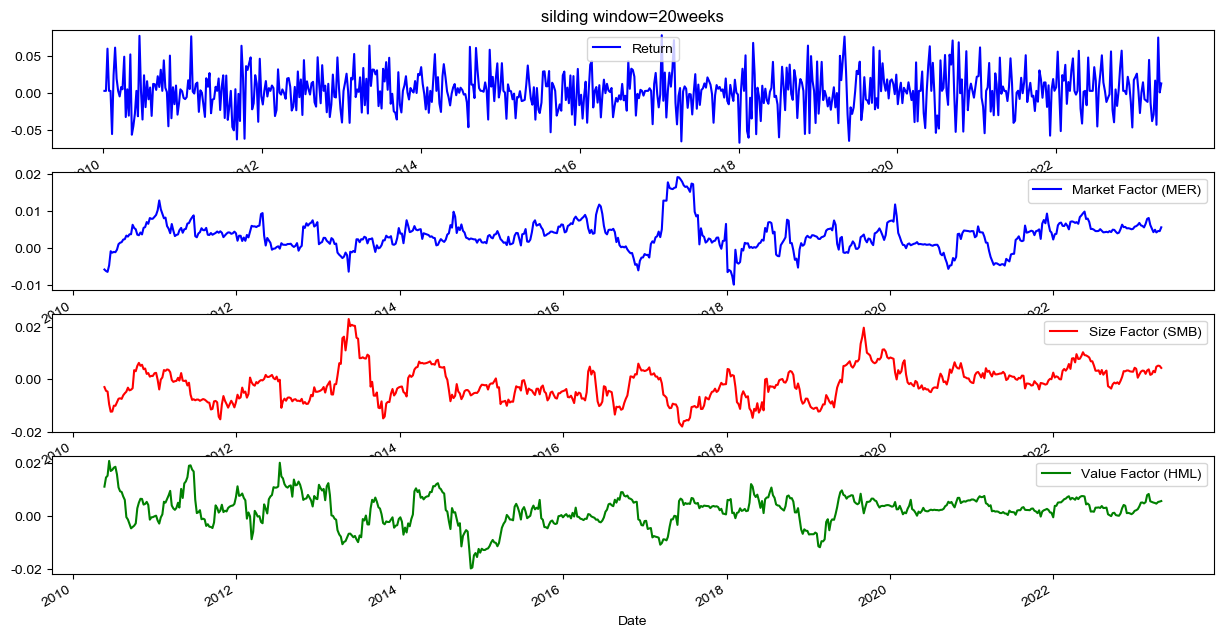

In [30]:
fig,ax = plt.subplots(nrows=4, ncols=1, figsize=(15,8))
df[['Return']].plot(ax=ax[0], color='blue', title='silding window=%sweeks' %window_size)
X_second_step[['Market Factor (MER)']].plot(ax=ax[1], color='blue')
X_second_step[['Size Factor (SMB)']].plot(ax=ax[2], color='red')
X_second_step[['Value Factor (HML)']].plot(ax=ax[3], color='green')


In [ ]:
X_second_step